<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Uncertainty Quantification**

In [0]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Introduction**

Uncertainty quantification (UQ) is the science of quantitative characterization and reduction of uncertainties in both computational and real world applications. It tries to determine how likely certain outcomes are if some aspects of the system are not exactly known. Computer simulations are the most common approach to study problems in uncertainty quantification (read more: ['Uncertainty Quantification'](https://en.m.wikipedia.org/wiki/Uncertainty_quantification)).

**Sources of Uncertainty**

* Parameter: model parameters that are inputs to the model but whose exact values are unknown to experimentalists and cannot be controlled in physical experiments, or whose values cannot be exactly inferred by statistical methods.
* Parametric: comes from the variability of input variables of the model.
* Structural: Also known as model inadequacy, model bias, or model discrepancy, this comes from the lack of knowledge of the underlying physics in the problem.
* Algorithmic: known as numerical uncertainty, or discrete uncertainty. This type comes from numerical errors and numerical approximations per implementation of the computer model. Most models are too complicated to solve exactly.
* Experimental: observation error, this comes from the variability of experimental measurements. 
* Interpolation: lack of available data collected from computer model simulations and/or experimental measurements. For other input settings that don't have simulation data or experimental measurements, one must interpolate or extrapolate in order to predict the corresponding responses.

**Types of Uncertainty Quantification Problems**

1. forward propagation of uncertainty (where the various sources of uncertainty are propagated through the model to predict the overall uncertainty in the system response) 

2. inverse assessment of model uncertainty and parameter uncertainty (where the model parameters are calibrated simultaneously using test data). Getting increasing attention in the engineering design community, since uncertainty quantification of a model and the subsequent predictions of the true system response(s) are of great interest in designing robust systems.

For more details see ['Two types of uncertainty quantification problems'](https://en.m.wikipedia.org/wiki/Uncertainty_quantification#Two_types_of_uncertainty_quantification_problems), as well as ['Propagation of uncertainty'](https://en.m.wikipedia.org/wiki/Propagation_of_uncertainty) and ['Inverse Problem'](https://en.m.wikipedia.org/wiki/Inverse_problem).

*The following code examples to show how to fit regression models using TFP's 'probabilistic layers' are taken from this [Github](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb). Also read the article on ['Regression with Probabilistic Layers in TensorFlow Probability'](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html).*

# **Motivation & Data**

Use **TensorFlow Probabilistic Layers** to specify a probabilistic model (here: linear regression), and then simply minimize the negative log-likelihood. The **negative log-likelihood loss** function is (often used in combination with a SoftMax activation function) to define how well your neural network classifies data. The negative log-likelihood function is defined as **loss (y) = -log(y)** and produces a high value when the values of the output layer are evenly distributed and low.

In [0]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [0]:
# Synthesize dataset

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

**Ideal Case: No Uncertainty**

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(np.squeeze(w.numpy()) for w in model.weights)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

<generator object <genexpr> at 0x7f73716866d0>


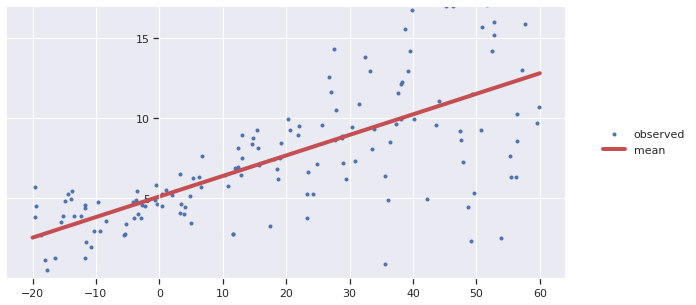

In [0]:
# Figure 1: No uncertainty

w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

#plt.figure(figsize=[6, 1.5])  # inches
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

# plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

# **Aleatoric Uncertainty (Known Unknowns)**

Aleatoric uncertainty is also known as statistical uncertainty, and is representative of unknowns that differ each time we run the same experiment. For example, a single arrow shot with a mechanical bow that exactly duplicates each launch (the same acceleration, altitude, direction and final velocity) will not all impact the same point on the target due to random and complicated vibrations of the arrow shaft, the knowledge of which cannot be determined sufficiently to eliminate the resulting scatter of impact points. 

**Approach**

In the previous section we’ve seen that there is variability in y for any particular value of x. We can treat this variability as being inherent to the problem. This means that even if we had an infinite training set, we still wouldn’t be able to predict the labels perfectly. A common example of this kind of uncertainty is the outcome of a fair coin flip (assuming you are not equipped with a detailed model of physics etc.). No matter how many flips we’ve seen in the past, we cannot predict what the flip will be in the future.

We will assume that this variability has a known functional relationship to the value of x. Let us model this relationship using the same linear function as we did for the mean of y.

In [0]:

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(np.squeeze(w.numpy()) for w in model.weights)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

<generator object <genexpr> at 0x7f73716866d0>


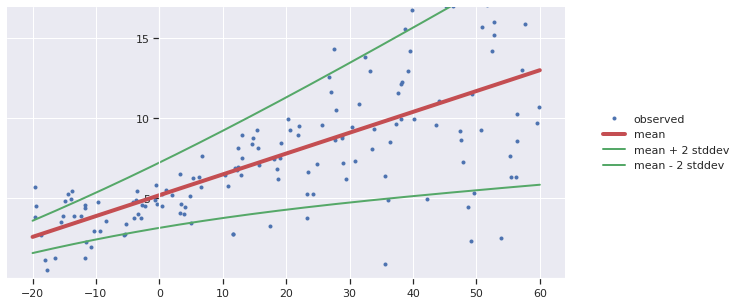

In [0]:
# Figure 2: Aleatoric Uncertainty
# plt.figure(figsize=[6, 1.5])  # inches
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

Better: the model is now less certain about what y should be as x gets larger. This kind of uncertainty is called aleatoric uncertainty, because it represents variation inherent to the underlying process . Though we’ve made progress, aleatoric uncertainty is not the only source of uncertainty in this problem. Before going further, let us consider the other source of uncertainty that we’ve hitherto ignored.

# **Epistemic Uncertainty (Unknown Unknowns)**

Epistemic uncertainty is also known as systematic uncertainty, and is due to things one could in principle know but do not in practice. This may be because a measurement is not accurate, because the model neglects certain effects, or because particular data has been deliberately hidden.

**Approach**

The noise in the data means that we can not be fully certain of the parameters of the linear relationship between x and y. For example, the slope we’ve found in the previous section seems reasonable, but we don’t know for sure, and perhaps a slightly shallower or steeper slope would also be reasonable. This kind of uncertainty is called the epistemic uncertainty; unlike aleatoric uncertainty, epistemic uncertainty can be reduced if we get more data. To get a sense of this uncertainty we shall replace the standard Keras Dense layer with TFP’s DenseVariational layer.

The DenseVariational layer uses a variational posterior Q(w) over the weights to represent the uncertainty in their values. This layer regularizes Q(w) to be close to the prior distribution P(w), which models the uncertainty in the weights before we look into the data.

For Q(w) we’ll use a multivariate normal distribution for the variational posterior with a trainable diagonal covariance matrix centered on a trainable location. For P(w) we’ll use a standard multivariate normal distribution for the prior with a trainable location and fixed scale. See Appendix B for more details about how this layer works.

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(np.squeeze(w.numpy()) for w in model.weights)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

<generator object <genexpr> at 0x7f736e701728>


Despite the complexity of the algorithms involved, using the DenseVariational layer is simple. One interesting aspect of the code above is that when we make predictions using a model with such a layer, we get a different answer every time we do so. This is because DenseVariational essentially defines an ensemble of models. Let us see what this ensemble tells us about the parameters of our model.

In [0]:
# Figure 3: Epistemic Uncertainty
# plt.figure(figsize=[6, 1.5])  # inches
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

Each line represents a different random draw of the model parameters from the posterior distribution. As we can see, there is in fact quite a bit of uncertainty about the linear relationship. Even if we don’t care about the variability of y for any particular value of x, the uncertainty in the slope should give us pause if we’re making predictions for x’s too far from 0.

Note that in this example we are training both P(w) and Q(w). This training corresponds to using Empirical Bayes or Type-II Maximum Likelihood. We used this method so that we wouldn’t need to specify the location of the prior for the slope and intercept parameters, which can be tough to get right if we do not have prior knowledge about the problem. Moreover, if you set the priors very far from their true values, then the posterior may be unduly affected by this choice. A caveat of using Type-II Maximum Likelihood is that you lose some of the regularization benefits over the weights. If you wanted to do a proper Bayesian treatment of uncertainty (if you had some prior knowledge, or a more sophisticated prior), you could use a non-trainable prior.

## **Aleatoric & Epistemic Uncertainty**

In real life applications, both kinds of uncertainties are present. Uncertainty quantification intends to work toward reducing epistemic uncertainties to aleatoric uncertainties. 

The **quantification for the aleatoric uncertainties** can be relatively straightforward to perform, depending on the application. Techniques such as the Monte Carlo method are frequently used. A probability distribution can be represented by its moments (in the Gaussian case, the mean and covariance suffice, although, in general, even knowledge of all moments to arbitrarily high order still does not specify the distribution function uniquely), or more recently, by techniques such as Karhunen–Loève and polynomial chaos expansions. 

To **evaluate epistemic uncertainties**, the efforts are made to gain better knowledge of the system, process or mechanism. Methods such as probability bounds analysis, fuzzy logic or evidence theory (Dempster–Shafer theory – a generalization of the Bayesian theory of subjective probability) are used.

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(np.squeeze(w.numpy()) for w in model.weights)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

<generator object <genexpr> at 0x7f0f2b3745c8>


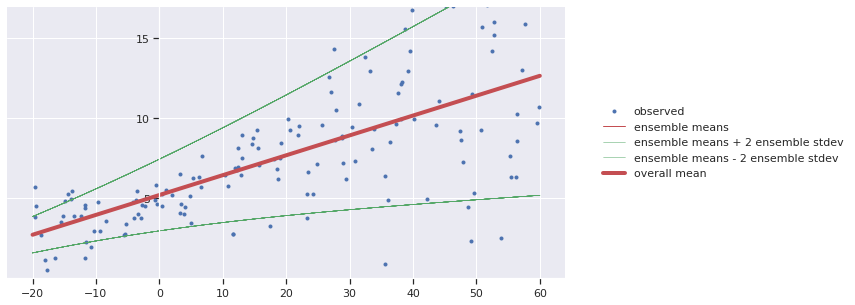

In [0]:
# Figure 4: Both Aleatoric & Epistemic Uncertainty
# plt.figure(figsize=[6, 1.5])  # inches
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

## **Functional Uncertainty**

Functional uncertainty quantification (FunUQ) was recently proposed to quantify uncertainties in models and simulations that originate from input functions, as opposed to parameters.

In [0]:
# Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [0]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model.
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

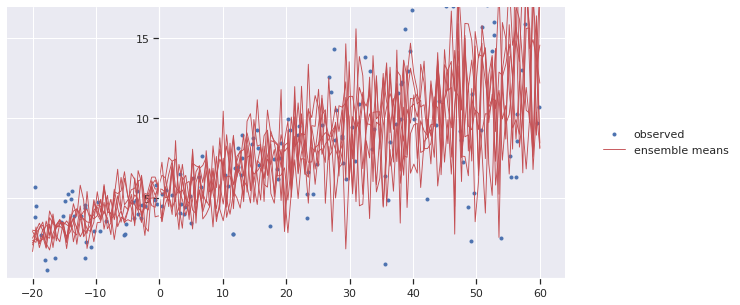

In [0]:
# Figure 5: Functional Uncertainty

y, x, _ = load_dataset()

# plt.figure(figsize=[6, 1.5])  # inches
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})
plt.plot(x, y, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig5.png', bbox_inches='tight', dpi=300)